<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/main/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import necessary libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
# from PIL import Image
# import glob
# train_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)
# from PIL import Image
# import glob
# valid_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)

train_path ='/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
test_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test'

In [5]:
# add preprocessing layer to the front of VGG
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - vgg has existing weights
for layer in vgg.layers:
  layer.trainable = False
  
 
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
folders = glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/*')

58900480/58889256 [==============================] - 1s 0us/step


In [6]:
# # our layers
# x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
# prediction = Dense(folders, activation='sigmoid')(x)
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# from keras import optimizers


# adam = optimizers.Adam()
# model.compile(loss='binary_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

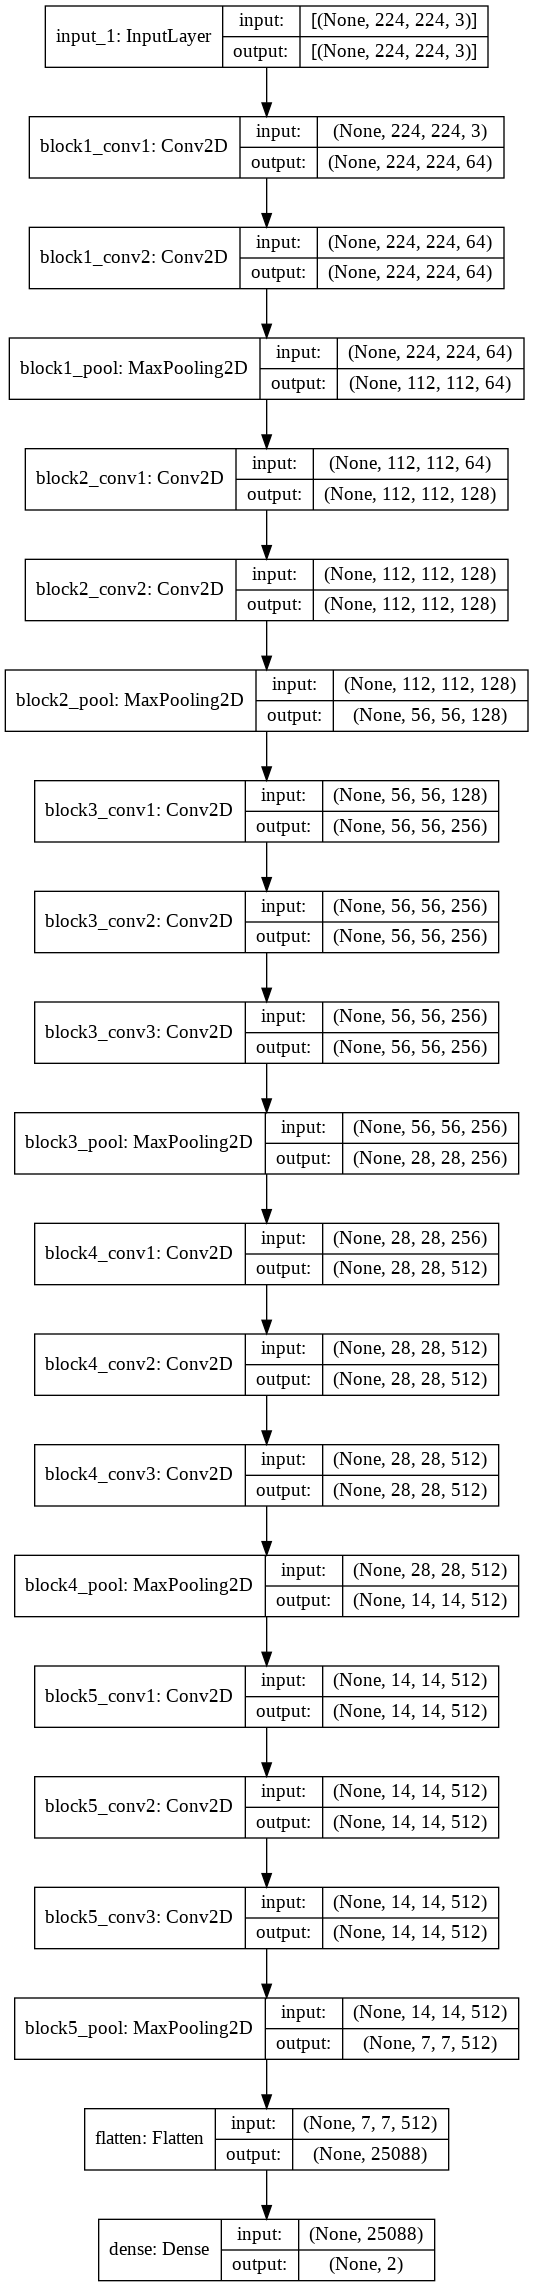

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'categorical')





Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [11]:
 # fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch= 20,  #len(training_set),
  validation_steps= 20 #len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 71s 2s/step - loss: 0.8510 - accuracy: 0.5625 - val_loss: 0.8692 - val_accuracy: 0.5250
Epoch 2/10
20/20 [==============================] - 32s 2s/step - loss: 0.7158 - accuracy: 0.6125 - val_loss: 0.7269 - val_accuracy: 0.5500
Epoch 3/10
20/20 [==============================] - 30s 2s/step - loss: 0.5587 - accuracy: 0.6625 - val_loss: 0.5933 - val_accuracy: 0.6875
Epoch 4/10
20/20 [==============================] - 25s 1s/step - loss: 0.5290 - accuracy: 0.7625 - val_loss: 0.4456 - val_accuracy: 0.7500
Epoch 5/10
20/20 [==============================] - 26s 1s/step - loss: 0.5758 - accuracy: 0.7125 - val_loss: 0.3559 - val_accuracy: 0.8625
Epoch 6/10
20/20 [==============================] - 22s 1s/step - loss: 0.8749 - accuracy: 0.5875 - val_loss: 1.2180 - val_accuracy: 0.5125
Epoch 7/10
20/20 [==============================] - 19s 977ms/step - loss: 0.5948 - accuracy: 0.6625 - val_loss: 0.4444 - val_accuracy: 0.8000
Epoch 8/10
20/20 

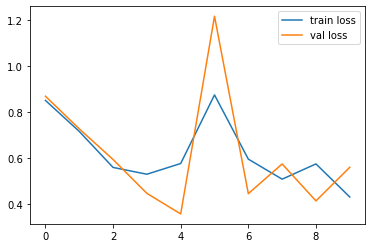

<Figure size 432x288 with 0 Axes>

In [12]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



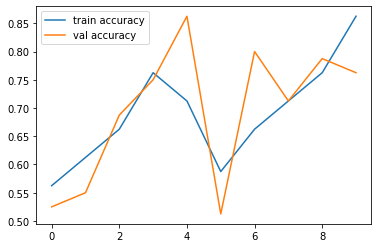

<Figure size 432x288 with 0 Axes>

In [13]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')


Input image shape: (1, 224, 224, 3)
[[6.0670004e-37 1.0000000e+00]]


'Spoof'

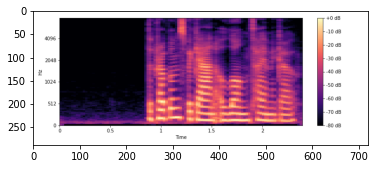

In [18]:
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import os, sys


img_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/Copy of LA_D_6787225.png'
#image1_dir = os.path.join(test_path+'/Bonafide/LA_D_4033093.png')

def import_and_predict(image_data, label):
  #resize 
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  x = np.expand_dims(img, axis=0)
  x = preprocess_input(x)

  print('Input image shape:', x.shape)

  my_image = imread(img_path)
  imshow(my_image)
      
  #predict image
  prediction = model.predict(x)
  print(prediction)

  label_prediction = label[np.argmax(prediction)]

  return label_prediction

label = os.listdir(test_path)


prediction = import_and_predict(img_path, label)
prediction

In [15]:
label

['Bonafide', 'Spoof']

In [16]:
# To save the model:
import tensorflow as tf

from keras.models import load_model

model.save('VGG16.h5')